# Item2Vec
In this notebook, we demonstarte how to learn embeddigns for items (products) from transactional data using Word2Vec. Orders are interpreted as sentences and product are interpreted as words.

### Data
We use an external dataset from the Instacart Market Basket Analysis competition (see `datasets.md/Instacart`). Please download and unzip the dataset to `data` folder before running this notebook.

### References
1. Barkan O., Koenigstein N. -- Item2Vec: Neural Item Embedding for Collaborative Filtering, 2016
1. Arora S., Warrier D. -- Decoding Fashion Contexts Using Word Embeddings, 2016

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import numpy as np
import os
import sys

from tabulate import tabulate
import glob
from IPython.display import display, HTML
import multiprocessing as mp
print('Number of CPU cores:', mp.cpu_count())

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import pairwise_distances

pd.options.display.max_rows = 20
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 200)
sns.set_style("whitegrid")


#
# Helper functions 
#
def to_readable(v):
    value = round(v,2) if isinstance(v, float) else v
    if value < 1000:
        return str(value)
    elif value < 1000000:
        return str(round(value/1000,1)) + 'K'
    elif value >= 1000000:
        return str(round(value/1000000,1)) + 'M'
    return value

def print_df(df, rows = 10, print_df_mode='psql'):
    if print_df_mode == 'psql':
        print(tabulate(df.head(rows), headers='keys', tablefmt='psql'))
    else:
        display(df.head(rows))
    print(f'{len(df)} rows x {len(df.columns)} columns')

Number of CPU cores: 16


# Step 1: Data Loading and Preview

In [45]:
if sys.platform == 'linux': path_sep = '/'
elif sys.platform[:3] == 'win': path_sep = '\\'
else: path_sep = '/'

DATA_PATH = os.path.join(os.getcwd(), 'data', 'shwapno')
files_list = glob.glob(f'{DATA_PATH}/*.csv')

data_dict = {}
for file in files_list:
    # print(f'\n\nReading: {file}')
    data = pd.read_csv(file)
    # print(data.info(null_counts=True))

    # print(f'\nSample ({file}):')
    # display(HTML(data.sample(min(10, len(data))).to_html()))
    # print(f'\nDataset stats ({file}):')
    # display(HTML(data.describe().T.to_html()))
    
    # print(f'\nColumn stats ({file}):')
    # for col in data.columns:
        # print(f'\nColumn {col} has {data[col].nunique()} unique values')
        # print(f"Example of values: {data[col].unique()[:10]}")

    data_dict[file.split(path_sep)[-1].split('.')[0]] = data
    
data_dict.keys()

dict_keys(['invoice_data'])

# Step 2: Data Preparation

In [46]:
product_code2name =data_dict['invoice_data'][['ProductCode','ProductName']].drop_duplicates().set_index('ProductCode').to_dict()['ProductName']
product_name2code =data_dict['invoice_data'][['ProductCode','ProductName']].drop_duplicates().set_index('ProductName').to_dict()['ProductCode']

data_dict['invoice_data'].ProductCode = data_dict['invoice_data'].ProductCode.astype(str)

baskets = data_dict['invoice_data'].loc[data_dict['invoice_data'].index.repeat(data_dict['invoice_data']['SalesQTY'])].groupby('Invoiceno')['ProductCode'].apply(list)
products_in_basket = data_dict['invoice_data'].loc[data_dict['invoice_data'].index.repeat(data_dict['invoice_data']['SalesQTY'])].groupby('Invoiceno')['ProductName'].apply(list)

other_elements = data_dict['invoice_data'][['Invoiceno','PrepareDate', 'WeekEndFlag', 'DayTimeFlag']].drop_duplicates().set_index(['Invoiceno'])
other_elements['PrepareDate'] = pd.to_datetime(other_elements.PrepareDate)

basket_corpus = pd.concat([baskets, products_in_basket, other_elements], axis=1)
daytime_dict = {key: i for i, key in enumerate(basket_corpus.DayTimeFlag.unique())}
basket_corpus.DayTimeFlag = basket_corpus.DayTimeFlag.map(daytime_dict)
# basket_corpus = basket_corpus.reset_index()

In [47]:
order_product_cnt_ds = basket_corpus.ProductCode.apply(len)
order_product_cnt_ds.rename('product_cnt', inplace=True)
order_ds = basket_corpus.merge(order_product_cnt_ds, left_on='Invoiceno', right_index=True)      # add product counters to orders
order_ds.sample(5)

ProductCode                                                                                                                                                                                              ProductName             PrepareDate  WeekEndFlag  DayTimeFlag  product_cnt
Invoiceno                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
D0072103200610  [2815899, 2815899, 2603654, 2603654, 3013410, 3013410, 3013410, 3013410, 3013410, 3013410, 3013410, 3013410, 3013410, 3013410, 3016707, 3016707, 3016707, 3016707, 3016708, 3016708]  [Bisk Club Potata Biscuits 100g(B2G1 Fre), Bisk Club Potata Biscuits 100g(B2G1 Fre), GK Fabric Roll-On Citrus flv. 8ml, GK Fabric Roll-On Citrus flv. 8ml, Himalaya Purifying Neem FW 150ml, Himalay... 2021-03-20 16:19:27.693            1            1           20
D0071712030349                                               [2803776, 2803776, 2810631, 2810632, 2810632, 2803422, 2805643, 2803792, 2808503, 2803607, 2804370, 2812787, 2812787, 2812787, 2812787]  [JB Coin Chocolate 168±18g, JB Coin Chocolate 168±18g, Cadbury Milk Tray Chocolate 180g, Celebrations Mix Pouch Chocolate 240g, Celebrations Mix Pouch Chocolate 240g, CHIKO Éclair Chocolate 500±50... 2017-12-03 14:49:18.007            0            1           15
D0072009110990                                                                                                     [2500998, 3010925, 2815185, 2501228, 2813599, 2813599, 2813599, 2815339, 2815339]  [Pran Dhaka Cheese 100g, Parachute Adv. Extra Care Hair Oil 150ml, Shwapno Sesame Burger Bun 200g, Aarong dairy Austagram Cheese 100g, Verda Penne Pasta 400g(BOGOF), Verda Penne Pasta 400g(BOGOF),... 2020-09-11 20:56:58.673            1            2            9
D0071602090184                                                                                                                       [2808565, 2808565, 2808565, 2400078, 2500577, 2800268, 2800268]  [Doodles Stick Noodles 300g, Doodles Stick Noodles 300g, Doodles Stick Noodles 300g, Fresh Soyabean Oil 5 ltr, Dano Sterilized Cream 170g, Meridian Thai Stick Noodles 180gm, Meridian Thai Stick No... 2016-02-09 11:30:19.250            0            0            7
D0072208270475                                                                                                                                                           [3005240, 2500087, 6000135]                                                                                                 [Sunsilk Stunning Black Shine Shampo350ml, Aarong Butter 200gm, PVC Bag Large (Shwapno Printed)-22"X18"] 2022-08-27 14:11:23.383            1            1            3

In [48]:
# total_user = len(order_ds.user_id.unique())
total_order = len(order_ds)
total_ordered_product = len(data_dict['invoice_data'])
unique_products = len(data_dict['invoice_data'].ProductCode.unique())

# print("total user = {}".format(to_readable(total_user)))
print("total order = {} (_ orders per user)".format(to_readable(total_order)  ))
print("total product = ", to_readable(unique_products))
print("total ordered product  = {} ({} orders per product)".format(to_readable(total_ordered_product), to_readable(total_ordered_product/unique_products) ))

total order = 233.9K (_ orders per user)
total product =  44.3K
total ordered product  = 1.7M (38.17 orders per product)


# Step 3: Prepare a Product Corpus

We now proceed to learning informative semantic representation for items (products) using word2vec model. The first step is to build a product corpus.

In [11]:
merge_order_product_df = data_dict['order_products__prior'].merge(order_ds, on='order_id' )

order_product_df = merge_order_product_df\
    .sort_values(['user_id','order_id','add_to_cart_order'])[['order_id','product_id', 'add_to_cart_order']]

# Print the input 
print_df(order_product_df)

print('Creating sequences based on transactions...')
order_product_list = order_product_df.values.tolist()



+---------+------------+--------------+---------------------+
|         |   order_id |   product_id |   add_to_cart_order |
|---------+------------+--------------+---------------------|
| 4089398 |     431534 |          196 |                   1 |
| 4089399 |     431534 |        12427 |                   2 |
| 4089400 |     431534 |        10258 |                   3 |
| 4089401 |     431534 |        25133 |                   4 |
| 4089402 |     431534 |        10326 |                   5 |
| 4089403 |     431534 |        17122 |                   6 |
| 4089404 |     431534 |        41787 |                   7 |
| 4089405 |     431534 |        13176 |                   8 |
| 4488095 |     473747 |          196 |                   1 |
| 4488096 |     473747 |        12427 |                   2 |
+---------+------------+--------------+---------------------+
32434489 rows x 3 columns
Creating sequences based on transactions...


In [13]:
# # Each entry of a corpus is one order represented by a chronologically sorted sequence of product IDs
# print('Preparing a corpus of items...')
# product_corpus = []
# sentence = []
# new_order_id = order_product_list[0][0]
# for (order_id, product_id, add_to_cart) in tqdm(order_product_list):
#     if new_order_id != order_id:
#         product_corpus.append(sentence)
#         sentence = []
#         new_order_id = order_id
#     sentence.append(str(product_id))

Preparing a corpus of items...


C:\Users\shadm\AppData\Local\Temp\ipykernel_17752\4163312409.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for (order_id, product_id, add_to_cart) in tqdm(order_product_list):


  0%|          | 0/32434489 [00:00<?, ?it/s]

In [32]:
product_corpus = order_ds.ProductCode.to_list()

# Step 4: Train Item2Vec model

To train the model, we use the Word2Vec implementation from Gensim adjusting the following parameters:
* sentences = product_corpus
* window - maximum distance between the current and predicted word within a sentence.
* size - dimensionality of the word vectors.
* min_count - ignores all words with total frequency lower than this.

In [49]:
TRAIN_ITEM_MODEL = True   # True - create a new model, False - load a previosuly created model
LOGGING_ENABLED = False
MODEL_DIR = 'models'

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [50]:
if LOGGING_ENABLED:
    import logging
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
    
WORD_DIM = 200
model_filename = f'models/item2vec.{WORD_DIM}d.model'
if TRAIN_ITEM_MODEL:
    model = Word2Vec(product_corpus, 
                window=5, 
                vector_size=WORD_DIM,
                workers=mp.cpu_count() - 2, 
                min_count=100)
    
    model.save(model_filename)
    print(f'Model saved to [{model_filename}]')
    
else:
    model = Word2Vec.load(model_filename)
    print(f'Model loaded from [{model_filename}]')

Model saved to [models/item2vec.200d.model]


In [53]:
def to_product_name(id):
    return product_code2name[id]

def most_similar_readable(model, product_id, topn=10):
    similar_list = [(product_id, 1.0)] + model.wv.most_similar(str(product_id), topn=topn)
    return pd.DataFrame([( to_product_name(int(id)), int(id), similarity ) for (id, similarity) in similar_list],
                        columns=['product', 'product_id', 'similarity'])

In [56]:
for product_id in [2700060, 2700060, 2701537, 2500093, 2500093, 2701738, 2701758, 2701714, 2300499]:
    print_df(most_similar_readable(model, product_id))

+----+---------------------------------------+--------------+--------------+
|    | product                               |   product_id |   similarity |
|----+---------------------------------------+--------------+--------------|
|  0 | Radhuni Haleem Mix 200 gm             |      2700060 |     1        |
|  1 | Rooh Afza 300 ml                      |      2300439 |     0.512028 |
|  2 | Pran Haleem Mix- 200 gm               |      2700061 |     0.498422 |
|  3 | Radhuni Jorda Mix 400g                |      2701744 |     0.495184 |
|  4 | Radhuni Chotpoti Masala 50 gm         |      2700054 |     0.478115 |
|  5 | Radhuni Mango Falooda Mix 250g        |      2702940 |     0.470198 |
|  6 | Aci Pure Halim Mix 200 gm             |      2700062 |     0.468814 |
|  7 | Radhuni Hyderabadi Biryani Masala 45g |      2703450 |     0.463136 |
|  8 | Radhuni Rademix Chicken Masala 100g   |      2702694 |     0.44228  |
|  9 | Radhuni Venilla Falooda Mix 250g      |      2702941 |     0.434037 |

In [55]:
order_ds.sample(5)


ProductCode                                                                                                                                                                                              ProductName             PrepareDate  WeekEndFlag  DayTimeFlag  product_cnt
Invoiceno                                                                                                                                                                                                                                                                                                                                                                                  
D0071609090785                    [2700060, 2700060, 2701537, 2500093, 2500093, 2701738, 2701758, 2701714, 2300499]  [Radhuni Haleem Mix 200 gm, Radhuni Haleem Mix 200 gm, Shwapno Kismis(Raisins)100gm, MARKS FULL CREAM MILK POWDER 500gm, MARKS FULL CREAM MILK POWDER 500gm, SHWAPNO Pesta (Pestacio) 25Gm, PROTIVA ... 2016-09-09 13:45:35.570            1            1            9
D0071605200577                                      [2700706, 2700706, 3012520, 2801554, 2801554, 3011942, 3351744]  [Haiko Paprika 20 gm, Haiko Paprika 20 gm, Castor Oil B.P 70ml Save tk-40/-, Cloud-9 Classic Chocolate 12g, Cloud-9 Classic Chocolate 12g, Dalan dOlive Color Protec.Shampoo 400ml, S201165 Towel Y ... 2016-05-20 12:21:33.470            1            0            7
D0071912300960                                               [2400777, 2400876, 2300500, 6000140, 2700096, 6000135]  [ACI Nutrilife Rice Bran Oil 2 Ltr (Pet), Shwapno Deshi Red Lentil 1Kg, Brooke Bond Taaza Danedar Tea 200g, NonWoven Tissue Bag Large (18"X15"), Aci Pure Dhonia Powder 100 gm, PVC Bag Large (Shwap... 2019-12-30 21:00:13.180            0            3            6
D0071505250518                                      [2300069, 2808520, 2807813, 2808588, 2800414, 2800414, 2500046]  [Nescafe Classic coffee 50gm (Glass btl), Ruchi Bar-B-Q Chanachur 150g, Gold Mark Original F.Cookie Biscuit 115g, Pran Mr. Noodles Easy Magic Masala 310g, Mr. Cookie (Big) Haque Biscuit 125 gm, Mr... 2015-05-25 20:44:09.297            0            2            7
D0071608140315  [3012737, 3012737, 3013051, 3013051, 2603158, 3006650, 3006650, 3006650, 3006650, 3006650, 3006650]  [Dove Soap 135g(Buy3 Get1 Free), Dove Soap 135g(Buy3 Get1 Free), Arko Sen.Foam Buy 200ml Get 100ml Free, Arko Sen.Foam Buy 200ml Get 100ml Free, Trix Lemon D.W.250ml(Buy2 Get1 Free), Pepsodent C8 ... 2016-08-14 12:41:29.647            0            0           11

# Step 5: Visualize the Semantic Space Using t-SNE

We demonstrate that the semantic space has a meaningful internal structure aligned with the typical product taxonomy (departments and aisles).

In [66]:
word_vectors = model.wv
# model.wv.index_to_key
model.wv['3102046']

numpy.ndarray

In [62]:
#
# Prepare the embeddings for t-SNE
#
word_vectors = model.wv
vocab = list(model.wv.index_to_key)
item2vector_dict = {arg:model.wv[arg] for arg in vocab}
X = pd.DataFrame(item2vector_dict).T.values
X.shape, len(vocab), vocab[0]

((3924, 200), 3924, '3102046')

In [67]:
item2vector_dict['3102046']

array([ 0.4331264 , -0.8245955 , -0.06425021,  0.8094878 , -0.8724794 ,
        0.13832682,  0.5837741 ,  0.62433654,  0.1729487 ,  0.3266257 ,
        0.70881325,  0.03742817,  0.12827426,  0.14024149, -1.3971556 ,
        0.26302254,  0.43733552, -0.9146197 , -0.99468744, -1.5988669 ,
        0.40731072,  0.45997825, -0.6972004 ,  0.5196537 , -0.9738727 ,
       -0.463844  ,  0.1069385 ,  0.4380946 , -0.7038488 ,  0.5294616 ,
        0.12539066,  0.24439058, -0.0222692 ,  0.4685799 , -1.2761121 ,
       -0.47696427,  0.3756622 ,  1.3359203 , -0.23070167, -0.26139167,
        0.3527965 ,  0.31241038,  0.2792321 , -0.22197603,  0.7804628 ,
        0.318884  , -0.56829554,  0.684509  ,  0.11504518,  0.06875668,
       -1.0305406 ,  0.03605509, -0.22674647,  0.4108149 ,  0.28439277,
       -0.2016415 ,  0.1720245 , -0.56224567, -0.17406777, -0.04164832,
        0.908525  , -1.2786602 ,  0.7475043 , -0.08162832,  0.66209984,
        1.9019092 ,  0.62555766,  0.00575481,  0.8777208 , -0.28

In [69]:
#
# Perform t-SNE
#
distance_matrix = pairwise_distances(X, X, metric='cosine', n_jobs=-1)
tsne = TSNE(metric="precomputed", n_components=2, verbose=1, perplexity=500, n_iter=1000, init='random')
tsne_results = tsne.fit_transform(distance_matrix)

[t-SNE] Computing 1501 nearest neighbors...
[t-SNE] Indexed 3924 samples in 0.103s...
[t-SNE] Computed neighbors for 3924 samples in 0.710s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3924
[t-SNE] Computed conditional probabilities for sample 2000 / 3924
[t-SNE] Computed conditional probabilities for sample 3000 / 3924
[t-SNE] Computed conditional probabilities for sample 3924 / 3924
[t-SNE] Mean sigma: 0.324567
[t-SNE] KL divergence after 50 iterations with early exaggeration: 53.352177
[t-SNE] KL divergence after 1000 iterations: 0.861552


In [74]:
len(vocab)

3924

In [70]:
df_semantic_item = pd.DataFrame({'product_id': vocab})
df_semantic_item['tsne-2d-one'] = tsne_results[:,0]
df_semantic_item['tsne-2d-two'] = tsne_results[:,1]
df_semantic_item['product_id'] = df_semantic_item['product_id'].astype(int)

df_semantic_item = df_semantic_item.merge(data_dict['products'], on='product_id', how='left')
df_semantic_item = df_semantic_item.merge(data_dict['aisles'], on='aisle_id', how='left')
df_semantic_item = df_semantic_item.merge(data_dict['departments'], on='department_id', how='left')

print_df(df_semantic_item.sample(5))

n_aisle = df_semantic_item['aisle'].nunique()
n_department = df_semantic_item['department'].nunique()
print(f"Unique aisles: {n_aisle}") 
print(f"Unique departments: {n_department}")

KeyError: 'products'

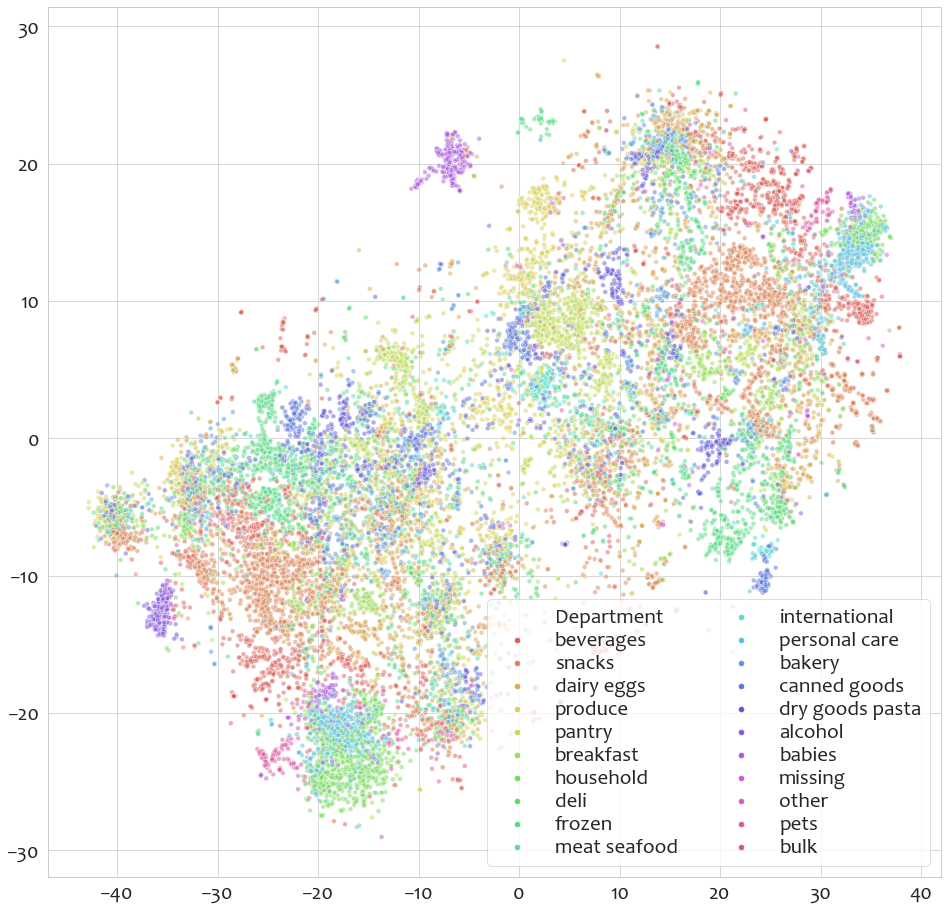

In [69]:
#
# Visualize the entire semantic space and its mapping to the departments
#
df_semantic_item.rename(columns={'department': 'Department'}, inplace=True)
plt.figure(figsize=(16, 16));
sns.set_context("paper", font_scale = 2.4);
sns.set_style({'font.family':'Candara', 'font.serif':['Candara']});
g = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='Department',
    palette=sns.color_palette("hls", n_department),
    data=df_semantic_item,
    legend="full",
    alpha=0.5
);
g.set(xlabel=None);
g.set(ylabel=None);
plt.legend(loc='lower right', labelspacing=0.15, ncol=2)
g.figure.savefig("item_space_tsne.pdf");
plt.show();

Products in the selected aisles: 2706


<Figure size 1152x1152 with 0 Axes>

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

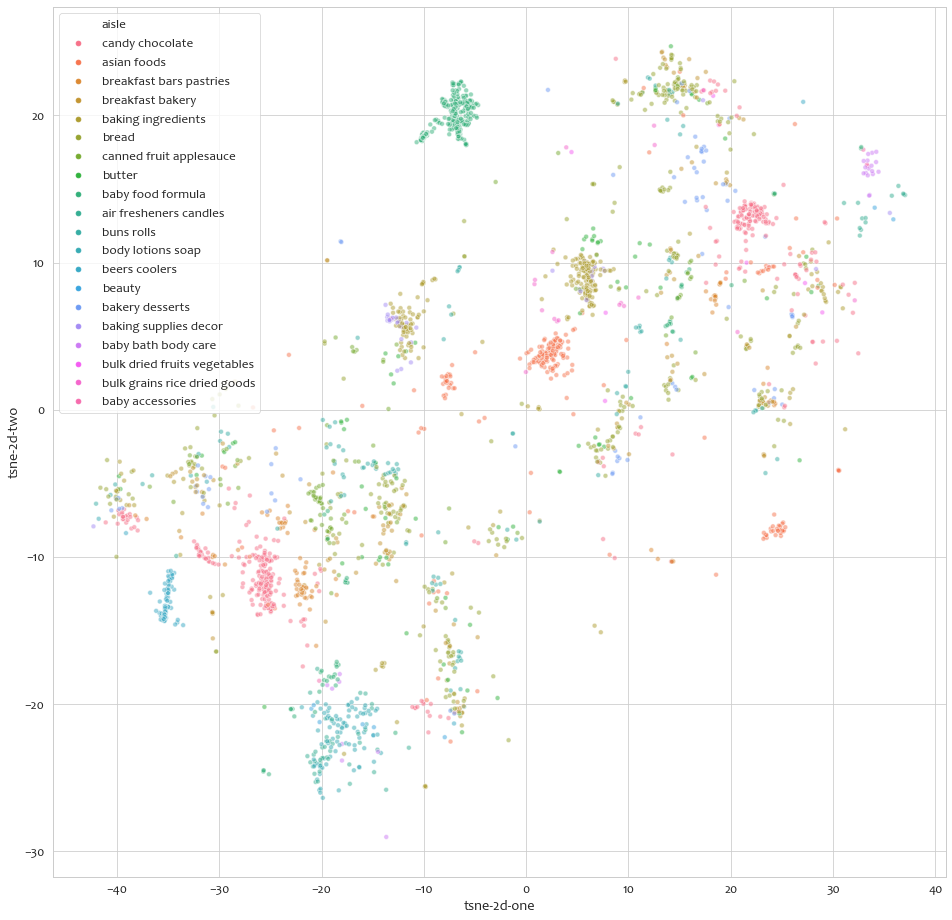

In [47]:
#
# Visualize the mapping between the semantic space and aisles
#
aisle_list = sorted(df_semantic_item['aisle'].unique())
aisle_set = aisle_list[:20]   # take a subset of aisles to keep it readable

print(f'Products in the selected aisles: {df_semantic_item[df_semantic_item.aisle.isin(aisle_set)].shape[0]}')
plt.figure(figsize=(16, 16))
sns.scatterplot(
   x="tsne-2d-one", y="tsne-2d-two",
   hue='aisle',
   data=df_semantic_item[df_semantic_item.aisle.isin(aisle_set)],
   legend="full",
   alpha=0.5
)
plt.show()

# Step 6: Compare the Original Semantic Space and Its t-SNE Projection

In this section, we compare the original (200 dimensional) semantic space with its t-SNE projection.

We demonstrate that rhe high-dimensional semantic space is better aligned with traditional labels (department, asile) than t-SNE projection. More basic projection methods provide event worse results - the SVD projection below is not aligned with the labels at all. However, the aligment between the traditional labels and semantic space is very weak (negative silhouette scores) anyways. This does not mean that the semantic space has no meanigful structure - the structure is just different from product depertment taxonomy. We study the strucutre in mode detail in Customer2Vec model.  

In [42]:
from sklearn.metrics import silhouette_samples, silhouette_score

for space_name, space in {'TSNE': tsne_results, 'raw latent space': model.wv.vectors}.items():
    for entity in ['department', 'aisle']:
        silhouette_avg = silhouette_score(space, df_semantic_item[entity], metric="cosine")
        print(f"The number of unique {entity}s is {df_semantic_item[entity].nunique()} " +\
              f"and the average silhouette_score on {space_name} is : {silhouette_avg:.4}")

The number of unique departments is 21 and the average silhouette_score on TSNE is : -0.7391
The number of unique aisles is 134 and the average silhouette_score on TSNE is : -0.8775
The number of unique departments is 21 and the average silhouette_score on raw latent space is : -0.05101
The number of unique aisles is 134 and the average silhouette_score on raw latent space is : -0.1159


<Figure size 576x576 with 0 Axes>

<AxesSubplot:xlabel='svd-2d-one', ylabel='svd-2d-two'>

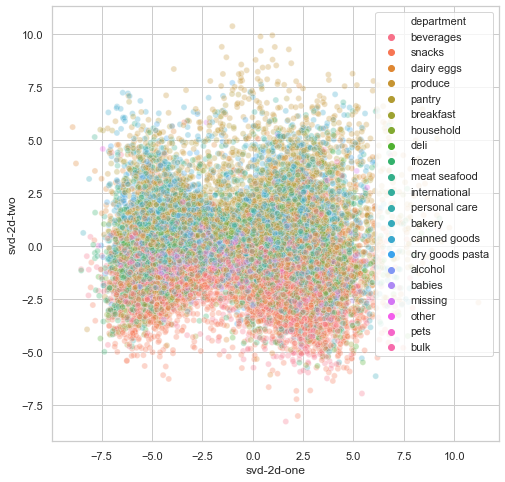

In [43]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)
X_reduced = svd.fit_transform(X)

df_svd = pd.DataFrame({'product_id': vocab})
df_svd['svd-2d-one'] = X_reduced[:,0]
df_svd['svd-2d-two'] = X_reduced[:,1]
df_svd['product_id'] = df_svd['product_id'].astype(int)

df_svd = df_svd.merge(data_dict['products'], on='product_id', how='left')
df_svd = df_svd.merge(data_dict['aisles'], on='aisle_id', how='left')
df_svd = df_svd.merge(data_dict['departments'], on='department_id', how='left')

plt.figure(figsize=(8, 8))
sns.scatterplot(
        x="svd-2d-one", y="svd-2d-two",
        hue='department',
        data=df_svd,
        legend="full",
        alpha=0.3
    )
plt.show()